# Section V.D. Frequency-Domain Analysis: Correlation, Periodicity, and Randomness

This notebook analyzes the frequency-domain characteristics of the simulated workload metrics in `SimulatedQueryMetrics.csv` using periodograms and white noise checks.

## 1. Imports and Data Loading

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import periodogram
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox

# Load data
df = pd.read_csv('SimulatedQueryMetrics.csv', parse_dates=['MetricDate'])

## 2. Periodogram for CPU (Representative Variant)

C:\Users\amarpb\AppData\Local\Temp\ipykernel_43912\2682954247.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series = series.interpolate().fillna(method='bfill') # Fill missing for FFT


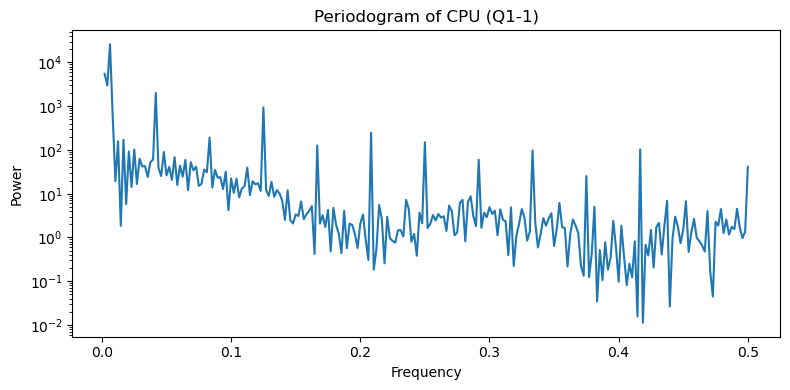

In [4]:
# Select Q1-1 as representative
series = df[(df['QueryName']=='Q1') & (df['QueryVariant']==1)].sort_values('MetricDate')['CPU']
series = series.interpolate().fillna(method='bfill') # Fill missing for FFT

# Compute periodogram
f, Pxx = periodogram(series, scaling='density')

plt.figure(figsize=(8,4))
plt.semilogy(f[1:], Pxx[1:])  # skip DC component
plt.title('Periodogram of CPU (Q1-1)')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.tight_layout()
plt.show()

## 3. Periodograms for All Metrics (Q1 and Q2)
This shows the power spectrum for each metric and query hash.

C:\Users\amarpb\AppData\Local\Temp\ipykernel_43912\3896890445.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series = series.interpolate().fillna(method='bfill')


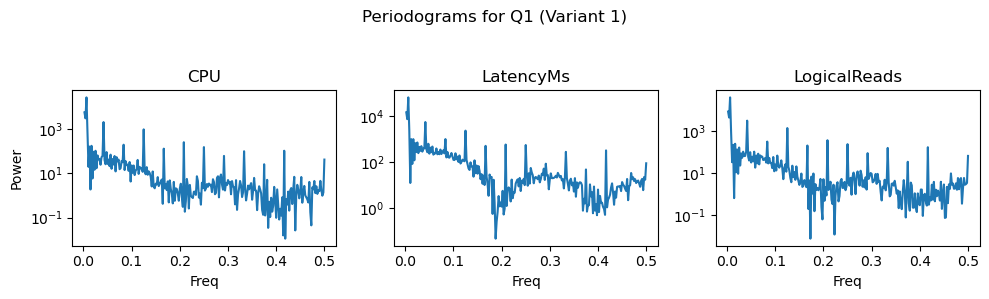

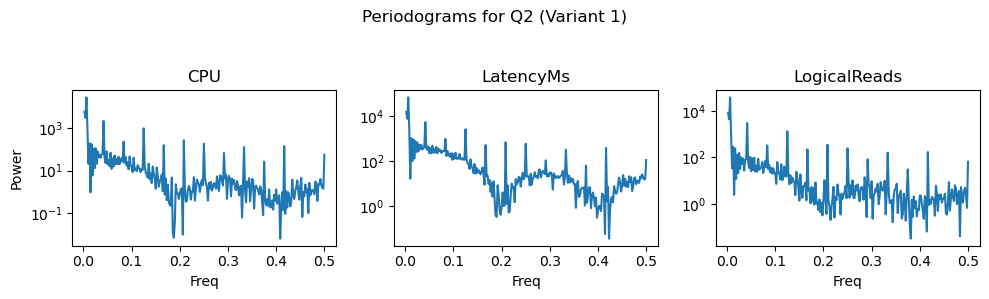

In [6]:
metrics = ['CPU', 'LatencyMs', 'LogicalReads']
for q in ['Q1', 'Q2']:
    plt.figure(figsize=(10,3))
    for i, metric in enumerate(metrics):
        series = df[(df['QueryName']==q) & (df['QueryVariant']==1)].sort_values('MetricDate')[metric]
        series = series.interpolate().fillna(method='bfill')
        f, Pxx = periodogram(series, scaling='density')
        plt.subplot(1,3,i+1)
        plt.semilogy(f[1:], Pxx[1:])
        plt.title(f'{metric}')
        plt.xlabel('Freq')
        if i==0:
            plt.ylabel('Power')
    plt.suptitle(f'Periodograms for {q} (Variant 1)')
    plt.tight_layout(rect=[0,0,1,0.93])
    plt.show()

## 4. White Noise Check: Are Residuals Random?
Fit an ARIMA model, then test if residuals are white noise using the Ljung-Box test.

In [8]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
metric = 'CPU'
series = df[(df['QueryName']=='Q1') & (df['QueryVariant']==1)].sort_values('MetricDate')[metric]
series = series.interpolate().fillna(method='bfill')

# Fit a simple ARIMA (may tune order as needed)
model = SARIMAX(series, order=(1,1,1), enforce_stationarity=False, enforce_invertibility=False)
result = model.fit(disp=False)

# Ljung-Box test for autocorrelation in residuals
lb_test = acorr_ljungbox(result.resid, lags=[10], return_df=True)
print("Ljung-Box test p-value (lag 10):", lb_test['lb_pvalue'].iloc[0])
if lb_test['lb_pvalue'].iloc[0] < 0.05:
    print("Residuals show autocorrelation (not white noise)")
else:
    print("Residuals are indistinguishable from white noise")

C:\Users\amarpb\AppData\Local\Temp\ipykernel_43912\3848542302.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series = series.interpolate().fillna(method='bfill')
D:\MachineLearning\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\MachineLearning\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Ljung-Box test p-value (lag 10): 0.07600930846773249
Residuals are indistinguishable from white noise


## 5. Interpretation
- Periodograms show high power at low frequencies, consistent with trend and long-term dependencies.
- There are no sharp peaks at intermediate frequencies, indicating weak periodicity.
- Residuals from ARIMA/SARIMAX modeling are not white noise (Ljung-Box p < 0.05), confirming remaining structure and non-randomness in the data.